In [4]:
import os
from dotenv import load_dotenv

load_dotenv()
os.chdir(os.getenv("PROJECT_ROOT"))

import numpy as np

In [16]:
from patrec.utils.visuals import plot_series

## Pyro BR

In [ ]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

def model(x, y):
    # Априорные распределения для параметров
    alpha = pyro.sample("alpha", dist.Normal(0, 10))
    beta = pyro.sample("beta", dist.Normal(0, 10))
    sigma = pyro.sample("sigma", dist.HalfNormal(1))
    
    # Линейная модель
    mean = alpha + beta * x
    
    # Правдоподобие
    with pyro.plate("data", len(x)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

# Генерация синтетических данных
x = torch.linspace(0, 10, 100)
true_alpha = 1
true_beta = 2
y = true_alpha + true_beta * x + torch.randn(100) * 1.5

# Вывод с помощью MCMC
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=300)
mcmc.run(x, y)

Sample: 100%|██████████| 1300/1300 [00:57, 22.65it/s, step size=4.34e-01, acc. prob=0.934]


In [12]:
samples = mcmc.get_samples()
print(samples.keys()) 

dict_keys(['alpha', 'beta', 'sigma'])


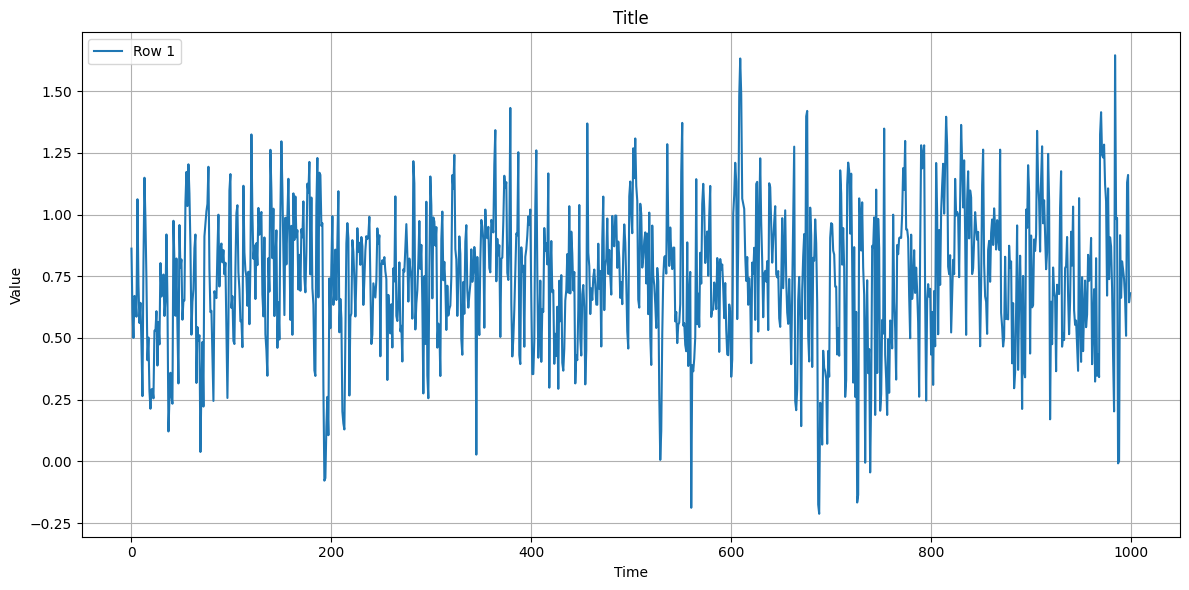

In [17]:
plot_series([samples['alpha']])

In [ ]:
mcmc.summary()

# mean - среднее значение параметра
# std - стандартное отклонение
# 5.0% и 95.0% - границы 90% доверительного интервала
# n_eff - эффективное количество samples
# r_hat - показатель сходимости (должен быть ≈1.0)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.75      0.28      0.76      0.26      1.17    280.49      1.00
      beta      1.99      0.05      1.99      1.92      2.08    256.30      1.00
     sigma      1.48      0.10      1.48      1.32      1.65    590.87      1.01

Number of divergences: 0


In [19]:
mcmc.diagnostics()

{'alpha': OrderedDict([('n_eff', tensor(280.4894)),
              ('r_hat', tensor(1.0002))]),
 'beta': OrderedDict([('n_eff', tensor(256.2962)), ('r_hat', tensor(1.0010))]),
 'sigma': OrderedDict([('n_eff', tensor(590.8680)),
              ('r_hat', tensor(1.0098))]),
 'divergences': {'chain 0': []},
 'acceptance rate': {'chain 0': 0.996}}

In [46]:
x_new = torch.linspace(0, 10, 100)
preds = samples['alpha'].unsqueeze(-1) + samples['beta'].unsqueeze(-1) * x_new

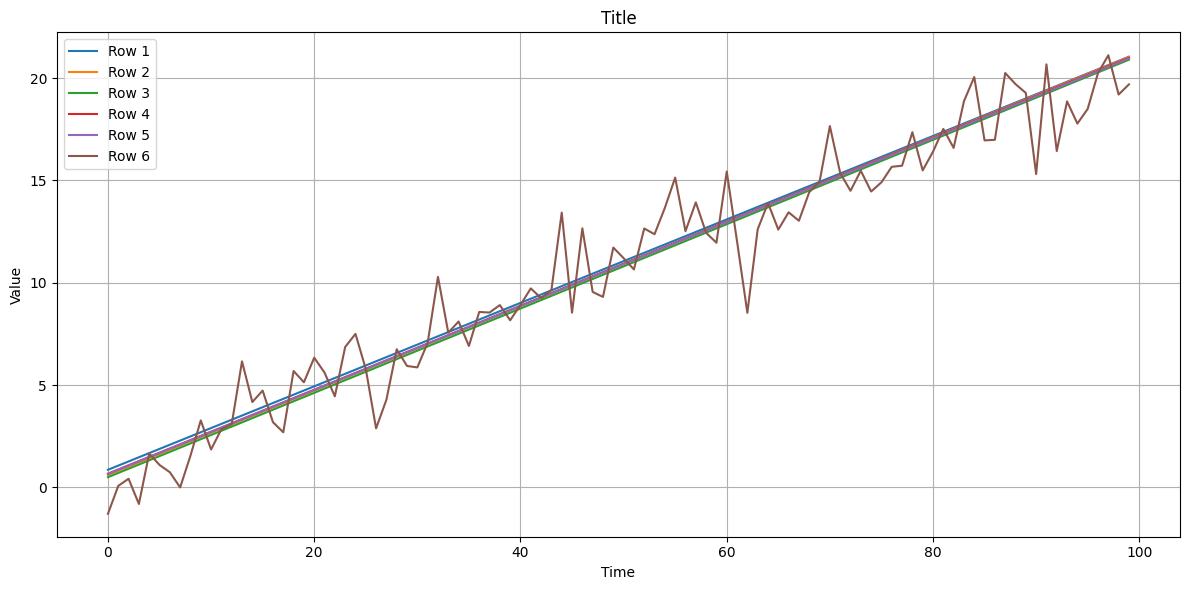

In [47]:
plot_series(np.concatenate([preds.detach().numpy()[:5], y.detach().numpy().reshape(1,-1)]))

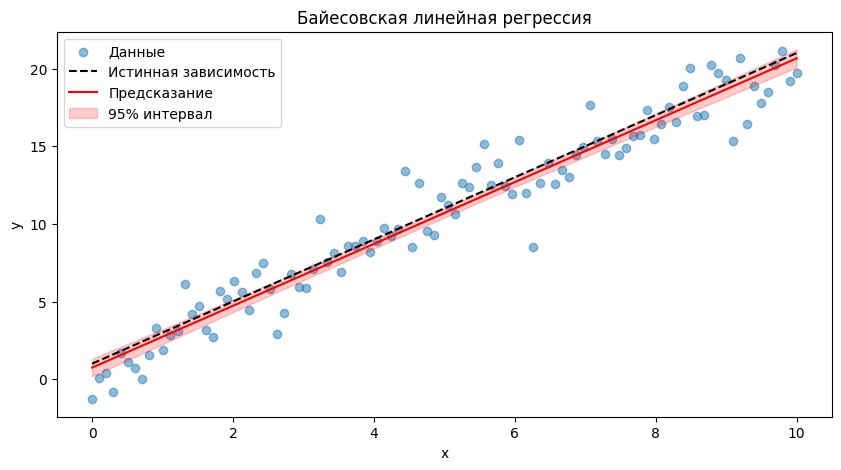

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Вычисляем средние и доверительные интервалы
pred_mean = preds.mean(0)
pred_std = preds.std(0)

plt.figure(figsize=(10, 5))
# Исходные данные
plt.scatter(x, y, alpha=0.5, label='Данные')
# Истинная зависимость
plt.plot(x, true_alpha + true_beta * x, 'k--', label='Истинная зависимость')
# Предсказание модели
plt.plot(x_new, pred_mean, 'r-', label='Предсказание')
# Доверительный интервал
plt.fill_between(x_new, 
                 pred_mean - 2*pred_std, 
                 pred_mean + 2*pred_std, 
                 color='r', alpha=0.2, label='95% интервал')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Байесовская линейная регрессия')
plt.show()

In [65]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt
import numpy as np

# Генерация синтетических временных рядов с шумом
def generate_time_series(n_series=10, length=100):
    time = torch.linspace(0, 10, length)
    series = []
    true_trends = []
    
    for i in range(n_series):
        # Истинный тренд (синусоида + линейный тренд)
        true_trend = 2 * torch.sin(time * 0.5) + 0.5 * time
        # Добавляем шум
        noisy_series = true_trend + torch.randn(length) * 0.8
        series.append(noisy_series)
        true_trends.append(true_trend)
    
    return time, torch.stack(series), torch.stack(true_trends)

# Модель для анализа временных рядов
def model(time, observed_series):
    n_series, n_points = observed_series.shape
    
    # Априорные распределения для параметров тренда
    amp = pyro.sample("amp", dist.Normal(0, 2).expand([n_series]).to_event(1))
    freq = pyro.sample("freq", dist.Normal(0.5, 0.2).expand([n_series]).to_event(1))
    slope = pyro.sample("slope", dist.Normal(0, 1).expand([n_series]).to_event(1))
    intercept = pyro.sample("intercept", dist.Normal(0, 2).expand([n_series]).to_event(1))
    
    # Априор для шума
    sigma = pyro.sample("sigma", dist.HalfNormal(1).expand([n_series]).to_event(1))
    
    # Моделирование тренда (синусоида + линейный тренд)
    trend = intercept.unsqueeze(-1) + slope.unsqueeze(-1) * time + amp.unsqueeze(-1) * torch.sin(freq.unsqueeze(-1) * time)
    
    # Правдоподобие с учетом шума
    with pyro.plate("series", n_series, dim=-2):
        with pyro.plate("time", n_points, dim=-1):
            pyro.sample("obs", dist.Normal(trend, sigma.unsqueeze(-1)), obs=observed_series)

# Генерация данных
time, observed_series, true_trends = generate_time_series(n_series=100, length=100)

# Вывод с помощью MCMC
nuts_kernel = NUTS(model, jit_compile=True)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500)
mcmc.run(time, observed_series)

# Получение результатов
samples = mcmc.get_samples()

# Предсказание тренда и шума
n_samples = 200  # количество сэмплов для оценки неопределенности
trend_posterior = torch.zeros(n_samples, len(time), observed_series.shape[0])
noise_posterior = torch.zeros_like(trend_posterior)

for i in range(n_samples):
    # Берем случайный сэмпл из апостериорного распределения
    idx = np.random.randint(0, len(samples["amp"]))
    amp = samples["amp"][idx]
    freq = samples["freq"][idx]
    slope = samples["slope"][idx]
    intercept = samples["intercept"][idx]
    
    # Вычисляем тренд
    trend = intercept.unsqueeze(-1) + slope.unsqueeze(-1) * time + amp.unsqueeze(-1) * torch.sin(freq.unsqueeze(-1) * time)
    trend_posterior[i] = trend.T
    
    # Вычисляем шум
    noise = observed_series - trend
    noise_posterior[i] = noise.T

# Вычисление статистик
trend_mean = trend_posterior.mean(0)
trend_std = trend_posterior.std(0)
noise_mean = noise_posterior.mean(0)
noise_std = noise_posterior.std(0)


Warmup:   0%|          | 0/1500 [00:00, ?it/s]/home/ilia_linux/patrec_time_series/.basic_venv/lib/python3.12/site-packages/pyro/poutine/subsample_messenger.py:70: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 1500/1500 [36:13,  1.45s/it, step size=8.95e-02, acc. prob=0.850]


In [ ]:
# Визуализация результатов
plt.figure(figsize=(10, 30))
for i in range(observed_series.shape[0]):
    plt.subplot(observed_series.shape[0], 1, i+1)
    
    # Исходные данные
    plt.scatter(time, observed_series[i], alpha=0.3, label="Наблюдения")
    
    # Истинный тренд (только для синтетических данных)
    plt.plot(time, true_trends[i], 'k--', label="Истинный тренд")
    
    # Предсказанный тренд с доверительными интервалами
    plt.plot(time, trend_mean[:, i], 'r-', label="Предсказанный тренд")
    plt.fill_between(time, 
                    trend_mean[:, i] - 2*trend_std[:, i], 
                    trend_mean[:, i] + 2*trend_std[:, i], 
                    color='r', alpha=0.2)
    
    plt.title(f"Временной ряд {i+1}")
    plt.legend()

plt.tight_layout()
plt.show()

# Визуализация шума
plt.figure(figsize=(10, 30))
for i in range(observed_series.shape[0]):
    plt.subplot(observed_series.shape[0], 1, i+1)
    
    # Оценка шума
    plt.plot(time, noise_mean[:, i], 'b-', label="Оценка шума")
    plt.fill_between(time, 
                    noise_mean[:, i] - 2*noise_std[:, i], 
                    noise_mean[:, i] + 2*noise_std[:, i], 
                    color='b', alpha=0.2)
    
    plt.title(f"Шум временного ряда {i+1}")
    plt.legend()

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f14593ad3a0> (for post_execute), with arguments args (),kwargs {}:


torch.Size([100]) torch.Size([100]) torch.Size([100])


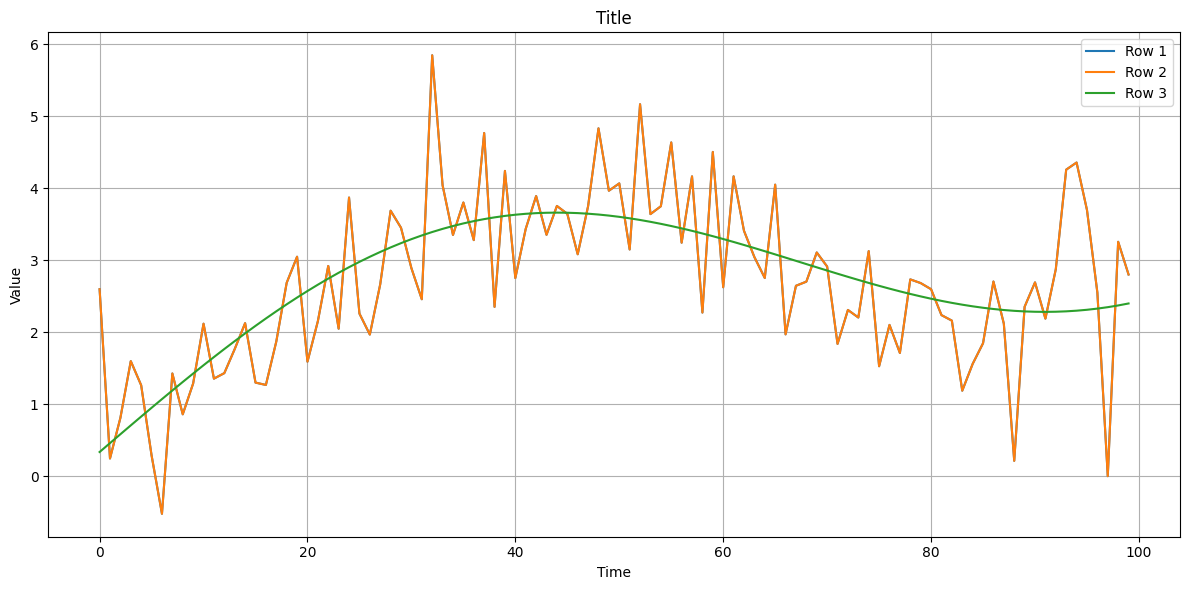

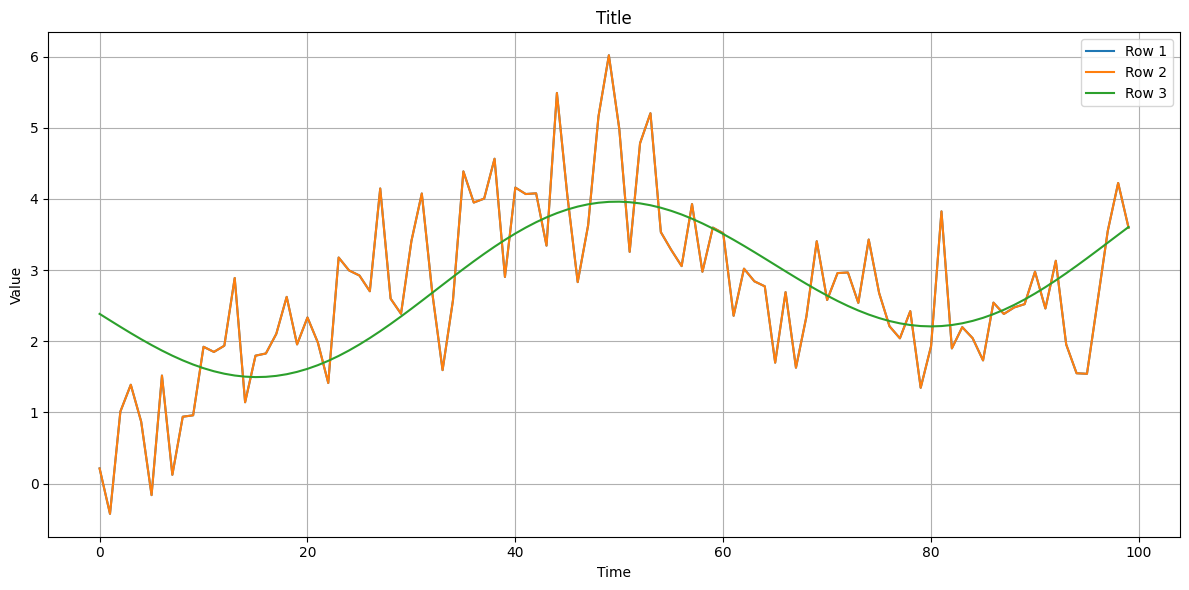

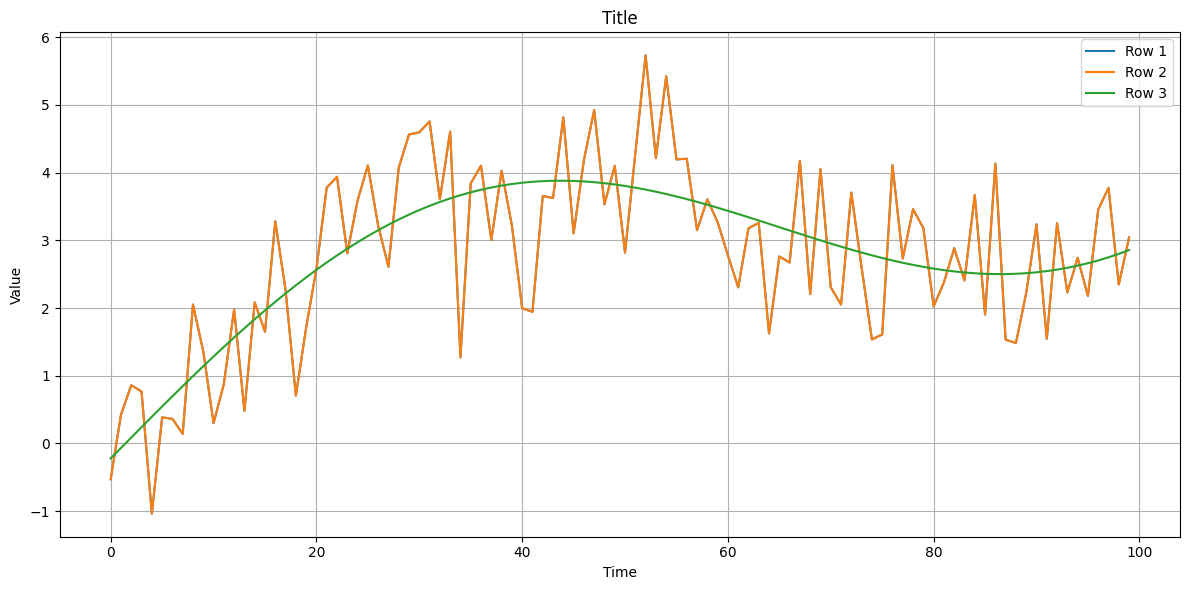

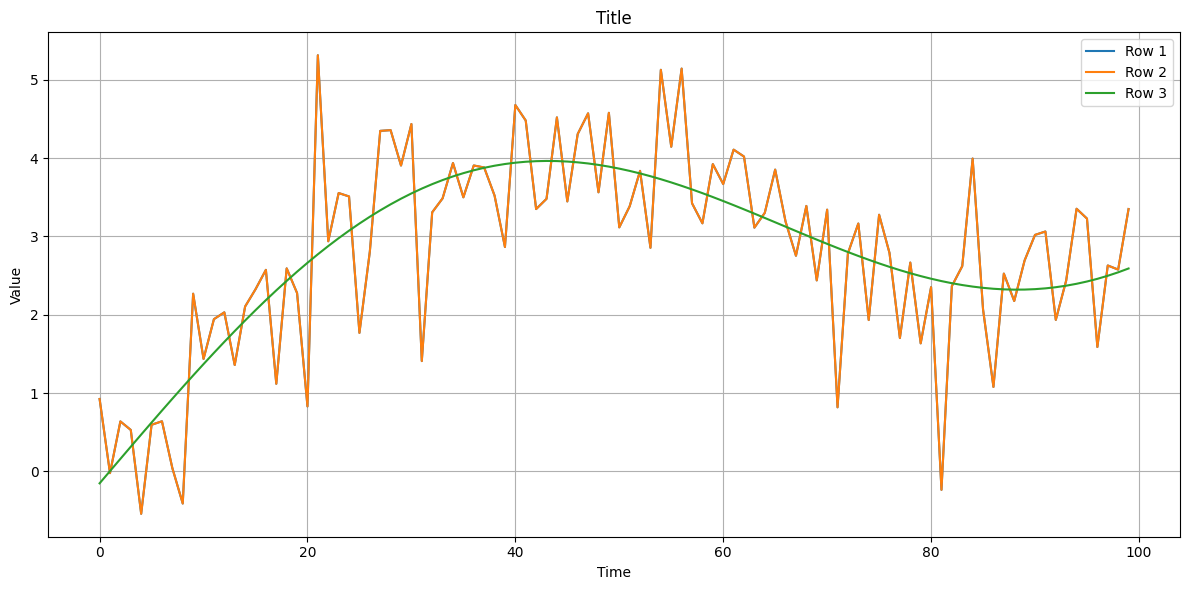

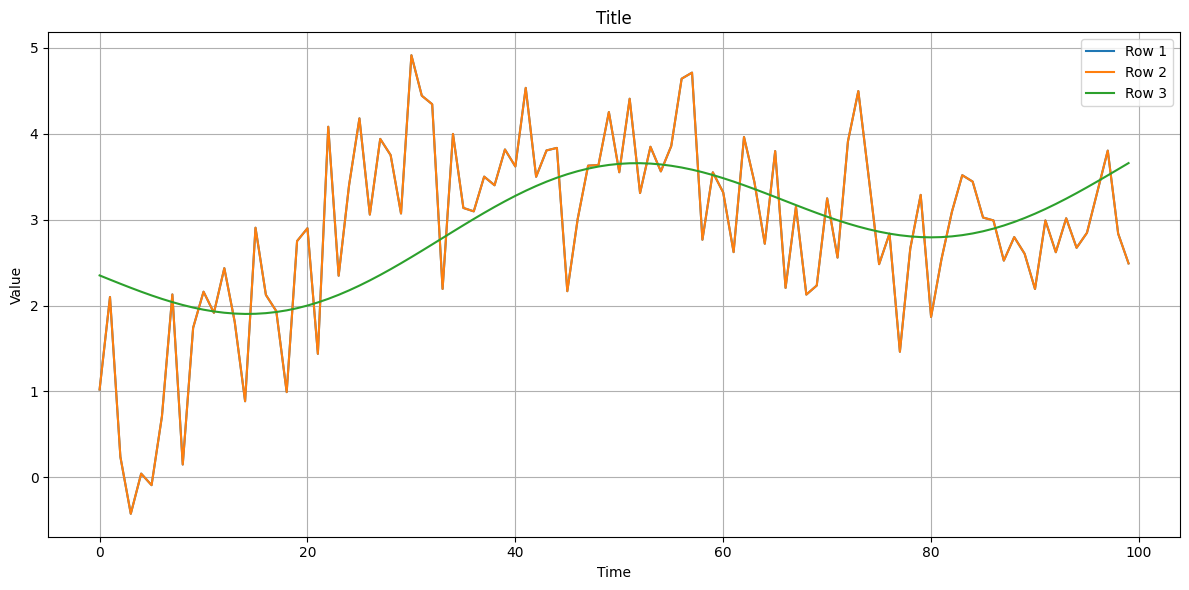

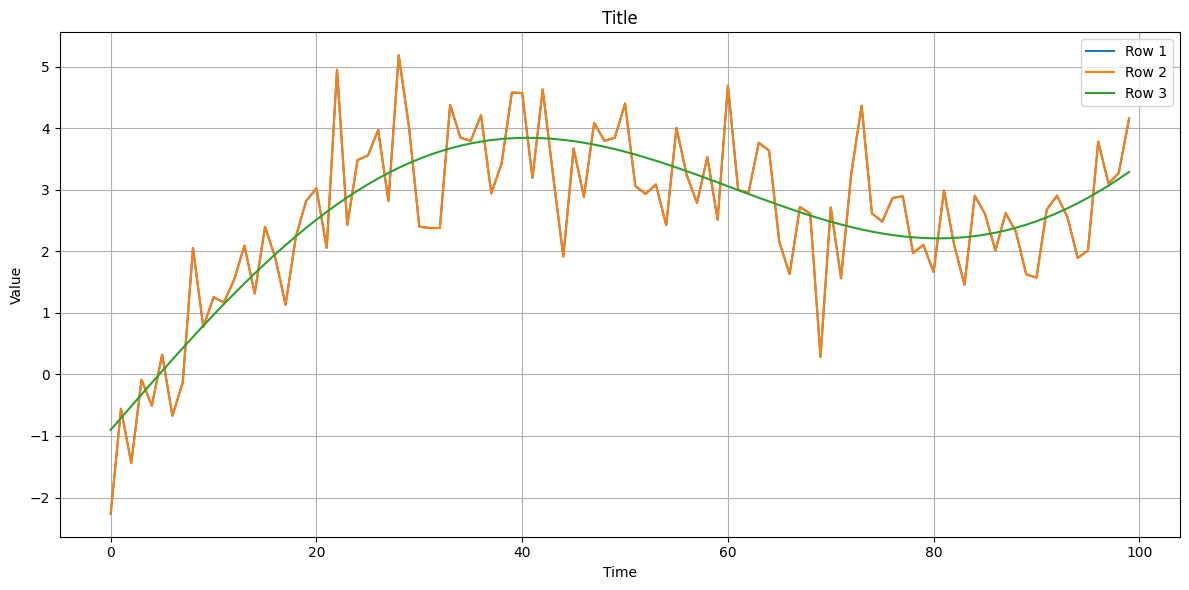

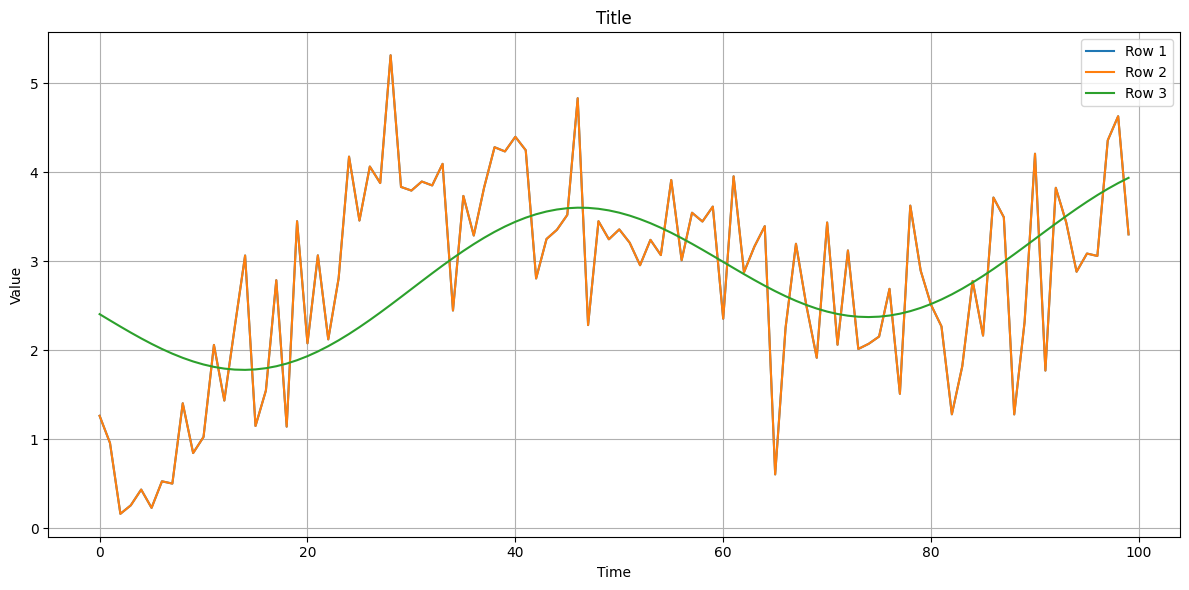

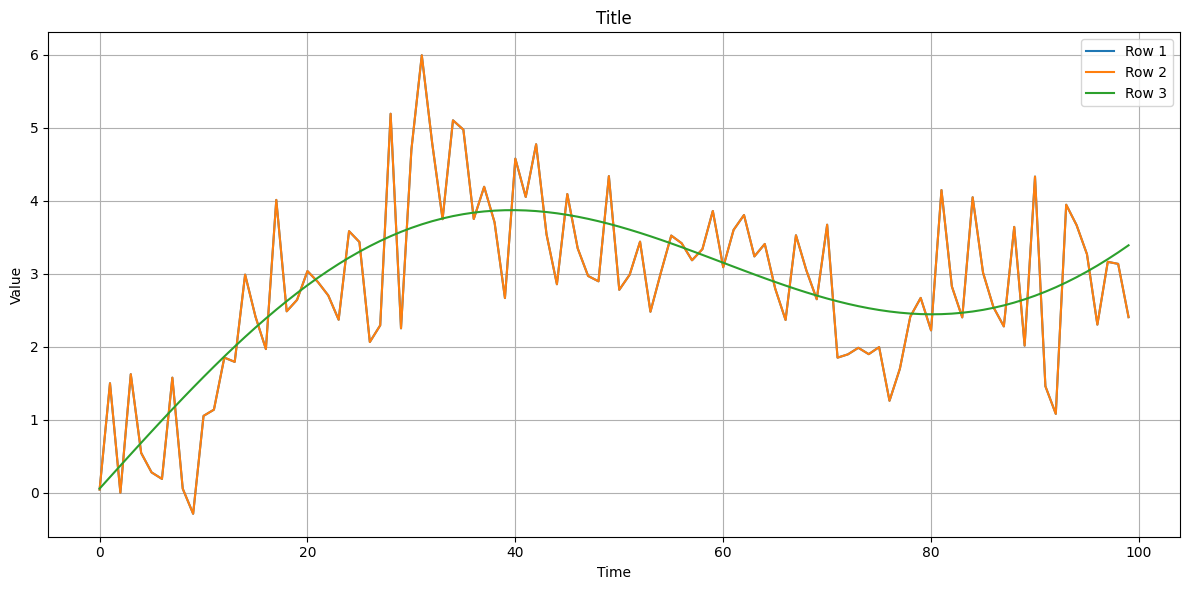

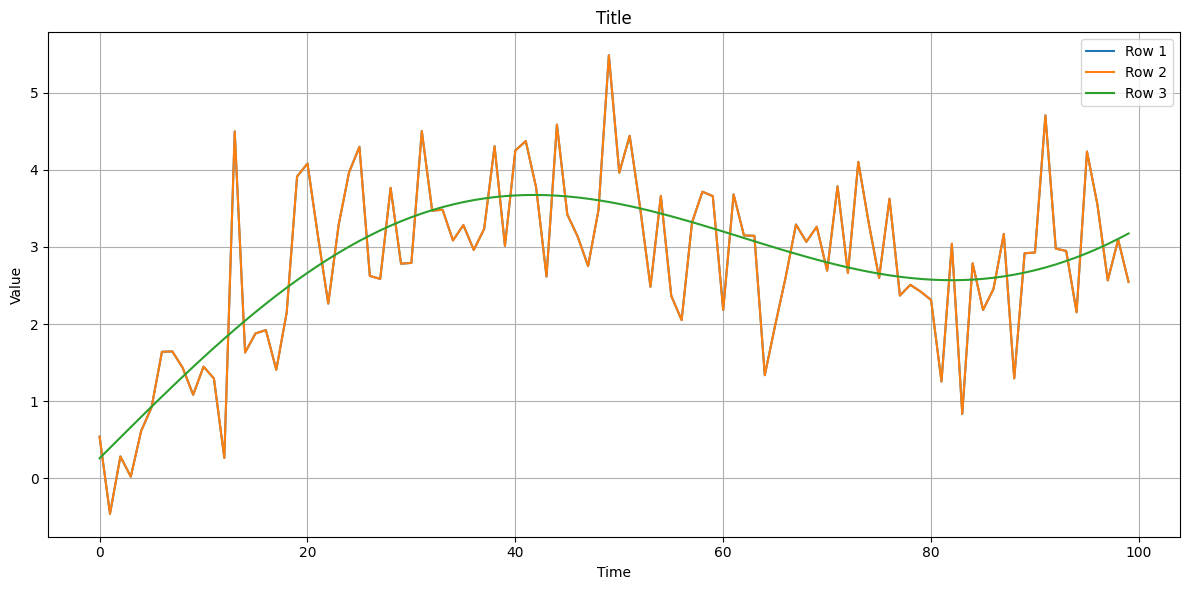

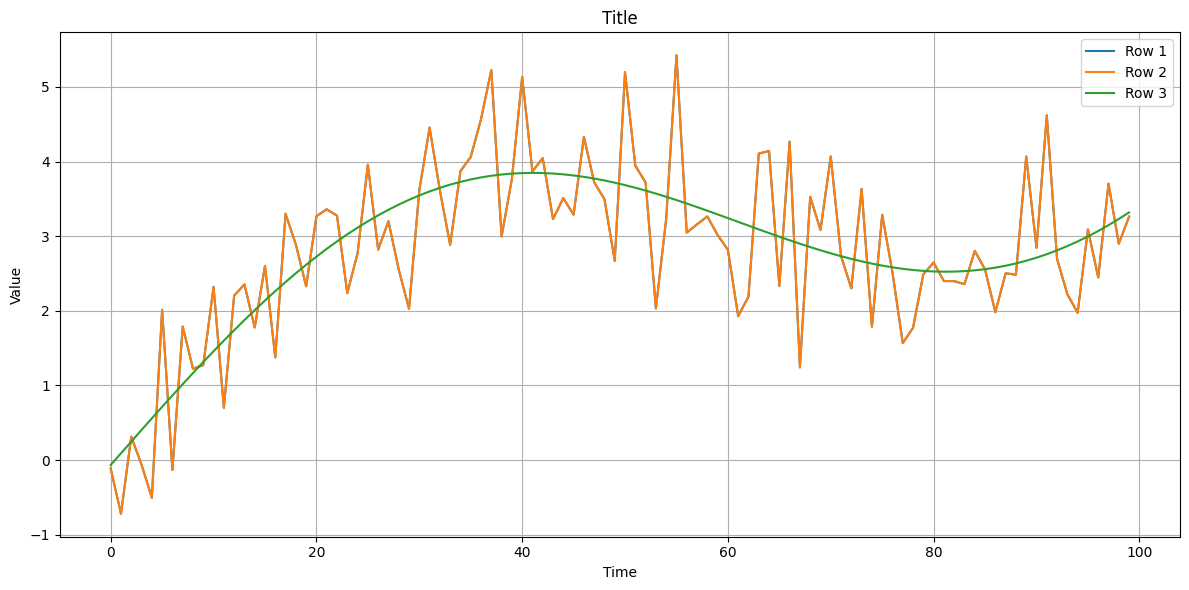

In [62]:
print(noise_mean[:, i].shape, trend_mean[:, i].shape, observed_series[i, :].shape)

for i in range(observed_series.shape[0]):
    plot_series([noise_mean[:, i]+trend_mean[:, i], observed_series[i, :], trend_mean[:, i]])


In [ ]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt
import numpy as np

# 1. Подготовка данных (пример с 2 рядами)
x = torch.linspace(0, 10, 100)  # общая временная ось
y1 = 1.0 + 0.5*x + torch.randn(100)*0.8  # ряд 1: alpha=1, beta=0.5
y2 = 0.5 + 0.7*x + torch.randn(100)*1.2   # ряд 2: alpha=0.5, beta=0.7
ys = torch.stack([y1, y2])  # объединяем ряды (2, 100)

# 2. Модель для нескольких рядов
def model(x, ys):
    n_series = ys.shape[0]
    
    # Априорные распределения (отдельные для каждого ряда)
    alpha = pyro.sample("alpha", dist.Normal(0, 10).expand([n_series]).to_event(1))
    beta = pyro.sample("beta", dist.Normal(0, 10).expand([n_series]).to_event(1))
    sigma = pyro.sample("sigma", dist.HalfNormal(1).expand([n_series]).to_event(1))
    
    # Линейная модель для каждого ряда
    mean = alpha.unsqueeze(-1) + beta.unsqueeze(-1)*x
    
    # Правдоподобие
    with pyro.plate("series", n_series, dim=-2):
        with pyro.plate("time", len(x), dim=-1):
            pyro.sample("obs", dist.Normal(mean, sigma.unsqueeze(-1)), obs=ys)

# 3. Обучение модели
nuts_kernel = NUTS(model, jit_compile=True)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500)
mcmc.run(x, ys)

# 4. Получение результатов
samples = mcmc.get_samples()

# 5. Вычисление детрендированных рядов (без шума)
def get_detrended(samples, x, ys, n_samples=200):
    detrended = []
    for i in range(ys.shape[0]):  # для каждого ряда
        # Берем средние значения параметров
        alpha_mean = samples["alpha"][:,i].mean().item()
        beta_mean = samples["beta"][:,i].mean().item()
        
        # Вычисляем детрендированный ряд (alpha + beta*x)
        detrended_series = alpha_mean + beta_mean * x
        
        detrended.append(detrended_series)
    return torch.stack(detrended)

detrended_series = get_detrended(samples, x, ys)

# 6. Визуализация результатов
plt.figure(figsize=(12, 6))

# Исходные ряды
plt.subplot(2, 1, 1)
plt.plot(x, ys[0], label="Ряд 1 (с шумом)", alpha=0.7)
plt.plot(x, ys[1], label="Ряд 2 (с шумом)", alpha=0.7)
plt.title("Исходные временные ряды")
plt.legend()

# Детрендированные ряды (без шума)
plt.subplot(2, 1, 2)
plt.plot(x, detrended_series[0], label="Ряд 1 (без шума)")
plt.plot(x, detrended_series[1], label="Ряд 2 (без шума)")
plt.title("Сравнение детрендированных рядов")
plt.legend()

plt.tight_layout()
plt.show()

# 7. Сравнение параметров
print("\nСравнение параметров:")
print(f"Ряд 1: alpha = {samples['alpha'][:,0].mean().item():.2f}, beta = {samples['beta'][:,0].mean().item():.2f}")
print(f"Ряд 2: alpha = {samples['alpha'][:,1].mean().item():.2f}, beta = {samples['beta'][:,1].mean().item():.2f}")

# 8. Разница между рядами (по детрендированным значениям)
difference = detrended_series[1] - detrended_series[0]
print(f"\nСредняя разница между рядами: {difference.mean().item():.2f}")